In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import metaflux
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import learn2learn as l2l

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(101)
torch.manual_seed(101)
import warnings
from tqdm import tqdm
import copy

import warnings
warnings.filterwarnings("ignore")

## Load and modify your hyperparameters of your task

In [186]:
# Specify variables
xcolumns = ["P_F", "LAI", "VPD_F", "EVI"] # "P_F", "LAI", "SW_IN_F", "VPD_F", "TA_F", "EVI"
ycolumn = "GPP_NT_VUT_REF" # "GPP_NT_VUT_REF", "RECO"

# Load the hyperparameters for your task
config_path = '../metaflux/configs/upscale_gpp.yaml'
hyper_args = metaflux.configs.get_hyperparams(config_path=config_path)

hyper_args['xcolumns'] = xcolumns
hyper_args['input_size'] = len(xcolumns)
hyper_args

{'epoch': 100,
 'hidden_size': 1024,
 'batch_size': 32,
 'input_size': 4,
 'meta_lr': 0.0001,
 'update_lr': 1e-05,
 'num_lstm_layers': 1,
 'max_meta_step': 2,
 'finetune_size': 0.2,
 'xcolumns': ['P_F', 'LAI', 'VPD_F', 'EVI']}

## Define your model

In [87]:
# Load model
model_type = "mlp" # currently supported models: ['lstm', 'bilstm', 'mlp']
model = metaflux.learner.Learner(input_size=hyper_args["input_size"], hidden_size=hyper_args["hidden_size"], model_type=model_type).to(device)

# Define MAML model around our model
maml = l2l.algorithms.MAML(model, lr=hyper_args["update_lr"], first_order=False)
opt = torch.optim.Adam(maml.parameters(), lr=hyper_args["meta_lr"])
loss = torch.nn.MSELoss(reduction="mean")

## Define dataloader

In [88]:
root_dir = '../../Data/processed/tropics_full/'

# Note that the inputs are normalized here. For non-temporal data, we specify time_window = 1
fluxnet_train = metaflux.dataloader.Fluxmetanet(root=root_dir, mode="train", x_columns=hyper_args["xcolumns"], y_column=ycolumn, time_column=None, time_window=1)
fluxnet_test = metaflux.dataloader.Fluxmetanet(root=root_dir, mode="test", x_columns=hyper_args["xcolumns"], y_column=ycolumn, time_column=None, time_window=1)

In [89]:
x, y = next(iter(fluxnet_train))
print(x.shape)
print(y.shape)

torch.Size([1, 4])
torch.Size([1])


## Training

In [187]:
def train_meta(runs, hyper_args, fluxnet_train, fluxnet_test, for_inference=False, verbose=False):
    meta_loss_metric = dict()

    for run in range(0,runs):
        model = metaflux.learner.Learner(input_size=hyper_args["input_size"], hidden_size=hyper_args["hidden_size"], model_type=model_type).to(device)
        maml = l2l.algorithms.MAML(model, lr=hyper_args["update_lr"], first_order=False)
        opt = torch.optim.Adam(maml.parameters(), lr=hyper_args["meta_lr"])
        schedule = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=hyper_args["epoch"])
        train_epoch, val_epoch = list(), list()
        
        for epoch in range(hyper_args["epoch"]):
            opt.zero_grad()
            train_error, val_error = 0.0, 0.0

            # Meta-training
            with torch.backends.cudnn.flags(enabled=False):
                learner = maml.clone().double()
                db_train = DataLoader(fluxnet_train, batch_size=hyper_args["batch_size"], shuffle=True)
                max_steps = min(hyper_args["max_meta_step"], len(db_train))

                for step, (x, y) in enumerate(db_train):
                    x, y = x.to(device), y.to(device)
                    support_x, query_x, support_y, query_y = train_test_split(x, y, test_size=0.2, random_state=42)
                    pred = learner(support_x)
                    error = loss(pred, support_y)
                    learner.adapt(error)

                    # Evaluation
                    pred = learner(query_x)
                    error = loss(pred, query_y)
                    error.backward(retain_graph=True)
                    train_error += error.item()

                    if (step + 1) == max_steps:
                        break
                
                for n, p in maml.named_parameters():
                    p.grad.data.mul_(1.0/step)
                
                opt.step()
                schedule.step()

                # Meta-testing
                learner = maml.clone(first_order=True).double()
                db_test = DataLoader(fluxnet_test, batch_size=hyper_args["batch_size"], shuffle=True)
                max_steps = min(hyper_args["max_meta_step"], len(db_test))
                
                for step, (x, y) in enumerate(db_test):
                    x, y = x.to(device), y.to(device)
                    support_x, query_x, support_y, query_y = train_test_split(x, y, test_size=hyper_args["finetune_size"], random_state=42)
                    pred = learner(support_x)
                    error = loss(pred, support_y)
                    learner.adapt(error)

                    pred = learner(query_x)
                    error = loss(pred, query_y)
                    val_error += error.item()

                    if (step + 1) == max_steps:
                        if (for_inference) and (epoch % int(hyper_args["epoch"] // 2)) == 0:
                            # Take gradient steps for the class finetuned
                            error.backward(retain_graph=True)
                            opt.step()
                        
                        train_epoch.append(train_error/step)
                        val_epoch.append(val_error/step)
                        break
            
            if verbose and ((epoch % 50 == 0) or (epoch == (hyper_args["epoch"] - 1))):
                print(f'Epoch: {epoch}, training loss: {train_epoch[epoch]}, validation loss: {val_epoch[epoch]}')

        meta_loss_metric.update({
            f"train_loss_{run}": train_epoch,
            f"val_epoch_{run}": val_epoch
        })

    return meta_loss_metric, maml

In [161]:
def train_base(runs, hyper_args, fluxnet_train, fluxnet_test, verbose=False):
    base_loss_metric = dict()

    for run in range(0,runs):
        model = metaflux.learner.Learner(input_size=hyper_args["input_size"], hidden_size=hyper_args["hidden_size"], model_type=model_type).double().to(device)
        opt = torch.optim.Adam(model.parameters(), lr=hyper_args["update_lr"])
        schedule = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=hyper_args["epoch"])
        train_epoch, val_epoch = list(), list()

        for epoch in range(hyper_args["epoch"]):
            train_error, val_error = 0.0, 0.0

            # Training
            db_train = DataLoader(fluxnet_train, batch_size=hyper_args["batch_size"], shuffle=True)
            max_steps = min(hyper_args["max_meta_step"], len(db_train))

            for step, (x, y) in enumerate(db_train):
                opt.zero_grad()
                x, y = x.to(device), y.to(device)
                train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
                pred = model(train_x)
                error = loss(pred, train_y)
                error.backward()
                opt.step()
                train_error += loss(model(test_x), test_y).item()

                if (step + 1) == max_steps:
                    schedule.step()
                    break
            

            # Testing
            db_test = DataLoader(fluxnet_test, batch_size=hyper_args["batch_size"], shuffle=True)
            max_steps = min(hyper_args["max_meta_step"], len(db_test))
            model_copy = copy.deepcopy(model)
            opt_copy = torch.optim.Adam(model_copy.parameters(), lr=hyper_args["update_lr"])

            for step, (x, y) in enumerate(db_test):
                opt_copy.zero_grad()
                x, y = x.to(device), y.to(device)
                train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=hyper_args["finetune_size"], random_state=42)
                pred = model_copy(train_x)
                error = loss(pred, train_y)

                # Akin to finetuning/adaptation step in meta-learning
                error.backward()
                opt_copy.step()
                train_error += error.item()

                with torch.no_grad():
                    pred = model_copy(test_x)
                    error = loss(pred, test_y)
                    val_error += error.item()
                
                if (step + 1) == max_steps:
                    train_epoch.append(train_error/step)
                    val_epoch.append(val_error/step)
                    del model_copy, opt_copy
                    break

            if verbose and ((epoch % 50 == 0) or (epoch == (hyper_args["epoch"] - 1))):
                print(f'Epoch: {epoch}, training loss: {train_epoch[epoch]}, validation loss: {val_epoch[epoch]}')

        base_loss_metric.update({
            f"train_loss_{run}": train_epoch,
            f"val_epoch_{run}": val_epoch
        })
        
    return base_loss_metric, model

Training meta-learning models
Epoch: 0, training loss: 32.422797742623416, validation loss: 132.96943600933741
Epoch: 50, training loss: 24.017615094243197, validation loss: 57.28881907993687
Epoch: 99, training loss: 33.95238277640436, validation loss: 34.26563828425821
Epoch: 0, training loss: 57.777396189565245, validation loss: 89.09898069869877
Epoch: 50, training loss: 19.861976189671687, validation loss: 68.79814754836897
Epoch: 99, training loss: 12.727336323810874, validation loss: 43.736360157548276
Epoch: 0, training loss: 40.00248604218978, validation loss: 81.7249318081453
Epoch: 50, training loss: 26.60011304181136, validation loss: 39.95868942705496
Epoch: 99, training loss: 12.82526255560734, validation loss: 51.15188089624329
Epoch: 0, training loss: 71.8743357972608, validation loss: 100.08129910270753
Epoch: 50, training loss: 17.021282921589307, validation loss: 32.285004664585614
Epoch: 99, training loss: 15.068894169943007, validation loss: 21.626176824889306
Epoc

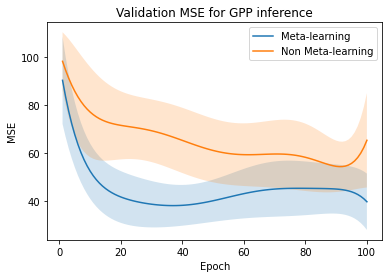

Non meta-learning loss: 46.29 ± 2.10
Meta-learning loss: 25.57 ± 1.13


In [108]:
runs = 5
meta_loss_metric, maml = train_meta(runs, hyper_args, fluxnet_train, fluxnet_test, for_inference=False)
base_loss_metric, model = train_base(runs, hyper_args, fluxnet_train, fluxnet_test)

# Plot validation loss
is_smoothing = True
smoothing_exp = 7
f, ax = plt.subplots()
epochs = np.arange(1,hyper_args["epoch"] + 1)
meta_loss, base_loss = list(), list()
for run in range(runs):
    meta_loss.append(meta_loss_metric[f"val_epoch_{run}"])
    base_loss.append(base_loss_metric[f"val_epoch_{run}"])

meta_loss = np.array(meta_loss)
base_loss = np.array(base_loss)
if is_smoothing:
    meta_mean = np.poly1d(np.polyfit(epochs, meta_loss.mean(axis=0), smoothing_exp))(epochs)
    meta_std = np.poly1d(np.polyfit(epochs, meta_loss.std(axis=0), smoothing_exp))(epochs)
    base_mean = np.poly1d(np.polyfit(epochs, base_loss.mean(axis=0), smoothing_exp))(epochs)
    base_std = np.poly1d(np.polyfit(epochs, base_loss.std(axis=0), smoothing_exp))(epochs)
else:
    meta_mean = meta_loss.mean(axis=0)
    meta_std = meta_loss.std(axis=0)
    base_mean = base_loss.mean(axis=0)
    base_std = base_loss.std(axis=0)

ax.plot(epochs, meta_mean, label='Meta-learning')
ax.plot(epochs, base_mean, label='Non Meta-learning')
ax.fill_between(epochs, meta_mean - meta_std, meta_mean + meta_std, alpha=0.2)
ax.fill_between(epochs, base_mean - base_std, base_mean + base_std, alpha=0.2)
ax.set_title("Validation MSE for GPP inference")
ax.set_ylabel("MSE")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

print(f"Non meta-learning loss: {min(base_loss.mean(axis=0)):.2f} ± {min(base_loss.std(axis=0)):.2f}")
print(f"Meta-learning loss: {min(meta_loss.mean(axis=0)):.2f} ± {min(meta_loss.std(axis=0)):.2f}")


In [28]:
# Save model
PATH = f"../../model_dir/maml_{model_type}_{ycolumn}.pt"
torch.save(maml, PATH)

# Extras

100%|██████████| 18/18 [2:46:04<00:00, 553.61s/it] 


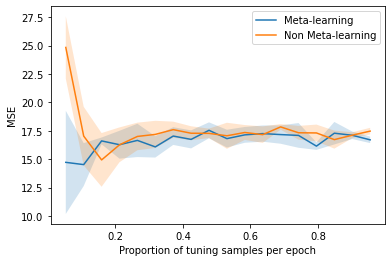

In [217]:
# Varying max_steps (ie. number of finetuning samples)
max_meta_steps = np.arange(2,len(fluxnet_test)//hyper_args["batch_size"],2)
hyper_args["epoch"] = 100 #Prevents the model from seeing too much of the data in later epochs
hyper_args["meta_lr"] = 1e-04 #Compensates for lower number of epoch to achieve convergence
runs = 5

meta_mean, meta_std, base_mean, base_std = list(), list(), list(), list()

for max_meta_step in tqdm(max_meta_steps):
    hyper_args["max_meta_step"] = max_meta_step
    meta_loss_metric, maml = train_meta(runs, hyper_args, fluxnet_train, fluxnet_test, for_inference=False, verbose=False)
    base_loss_metric, model = train_base(runs, hyper_args, fluxnet_train, fluxnet_test, verbose=False)
    meta_loss, base_loss = list(), list()
    for run in range(runs):
        meta_loss.append(np.min(meta_loss_metric[f"val_epoch_{run}"])); base_loss.append(np.min(base_loss_metric[f"val_epoch_{run}"]))
    
    meta_mean.append(np.array(meta_loss).mean()); meta_std.append(np.array(meta_loss).std()); base_mean.append(np.array(base_loss).mean()); base_std.append(np.array(base_loss).std())

meta_mean, meta_std, base_mean, base_std = np.array(meta_mean), np.array(meta_std), np.array(base_mean), np.array(base_std)

# Plotting
finetuning_prop = max_meta_steps * hyper_args["batch_size"] / len(fluxnet_test)
f, ax = plt.subplots()
ax.plot(finetuning_prop, meta_mean, label='Meta-learning')
ax.plot(finetuning_prop, base_mean, label='Non Meta-learning')
ax.fill_between(finetuning_prop, meta_mean - meta_std, meta_mean + meta_std, alpha=0.2)
ax.fill_between(finetuning_prop, base_mean - base_std, base_mean + base_std, alpha=0.2)
ax.set_ylabel("MSE")
ax.set_xlabel("Proportion of tuning samples per epoch")
ax.legend()
plt.show()